In [1]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

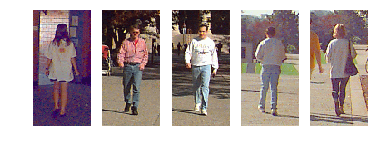

In [2]:
for i in range(5):
    filename = 'pedestrians128x64/per0010%d.ppm' % i
    img = cv2.imread(filename)
    plt.subplot(1,5,i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

In [4]:
win_size = (48, 96)
block_size = (16, 16)
block_stride = (8, 8)
cell_size = (8, 8)
num_bins = 9
hog = cv2.HOGDescriptor(win_size,
                        block_size,
                        block_stride,
                        cell_size,
                        num_bins)

In [6]:
import numpy as np
import random
random.seed(42)

In [8]:
X_pos = []
for i in random.sample(range(900), 400):
    filename = 'pedestrians128x64/per%05d.ppm' % i
    img = cv2.imread(filename)
    if img is None:
        print('Could not find image %s' % filename)
        continue
    X_pos.append(hog.compute(img, (64, 64)))

Could not find image pedestrians128x64/per00000.ppm


In [9]:
X_pos = np.array(X_pos, dtype=np.float32)
y_pos = np.ones(X_pos.shape[0], dtype=np.int32)
X_pos.shape, y_pos.shape

((399, 1980, 1), (399,))

In [22]:
import os
hroi = 128
wroi = 64
X_neg = []

In [23]:
for negfile in os.listdir('./pedestrians_neg'):
    filename = './pedestrians_neg/%s' % negfile
    img = cv2.imread(filename)
    img = cv2.resize(img, (512, 512))
    for j in range(5):
        rand_y = random.randint(0, img.shape[0] - hroi)
        rand_x = random.randint(0, img.shape[1] - wroi)
        roi = img[rand_y:rand_y + hroi, rand_x:rand_x + wroi, :]
        X_neg.append(hog.compute(roi, (64, 64)))

In [24]:
X_neg = np.array(X_neg, dtype=np.float32)

In [26]:
y_neg = -np.ones(X_neg.shape[0], dtype=np.int32)

In [28]:
X_neg.shape, y_neg.shape

((250, 1980, 1), (250,))

In [29]:
X = np.concatenate((X_pos, X_neg))
y = np.concatenate((y_pos, y_neg))

In [30]:
from sklearn import model_selection as ms
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
def train_svm(X_train, y_train):
    svm = cv2.ml.SVM_create()
    svm.train(X_train, cv2.ml.ROW_SAMPLE, y_train)
    return svm

In [42]:
def score_svm(svm, X, y):
    from sklearn import metrics
    _, y_pred = svm.predict(X)
    return metrics.accuracy_score(y, y_pred)

In [43]:
svm = train_svm(X_train, y_train)
score_svm(svm, X_train, y_train)

1.0

In [44]:
score_svm(svm, X_test, y_test)

1.0

In [45]:
score_train = []
score_test = []

In [46]:
for j in range(3):
    svm = train_svm(X_train, y_train)
    score_train.append(score_svm(svm, X_train, y_train))
    score_test.append(score_svm(svm, X_test, y_test))
    _, y_pred = svm.predict(X_test)
    false_pos = np.logical_and((y_test.ravel() == -1),
                               (y_pred.ravel() == 1))
    if not np.any(false_pos):
        print('no more false positive: done')
        break
    
    X_train = np.concatenate((X_train, X_test[false_pos, :]),
                             axis=0)
    y_train = np.concatenate((y_train, y_test[false_pos]),
                             axis=0)

no more false positive: done


In [47]:
score_train

[1.0]

In [48]:
score_test

[1.0]

In [49]:
img_test = cv2.imread('./pedestrian_test.jpg')

In [50]:
stride = 16
found = []

for ystart in np.arange(0, img_test.shape[0], stride):
    for xstart in np.arange(0, img_test.shape[1], stride):
        if ystart + hroi > img_test.shape[0]:
            continue
        if xstart + wroi > img_test.shape[1]:
            continue
        roi = img_test[ystart:ystart + hroi,
                       xstart:xstart + wroi, :]
        feat = np.array([hog.compute(roi, (64, 64))])
        _, ypred = svm.predict(feat)
        if np.allclose(ypred, 1):
            found.append((ystart, xstart, hroi, wroi))

In [55]:
rho, _, _ = svm.getDecisionFunction(0)
sv = svm.getSupportVectors()

In [56]:
hog.setSVMDetector(np.append(sv.ravel(), rho))

error: OpenCV(3.4.2) /Users/travis/build/skvark/opencv-python/opencv/modules/objdetect/src/hog.cpp:117: error: (-215:Assertion failed) checkDetectorSize() in function 'setSVMDetector'
